In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import (Dense, Activation, Flatten, Dropout, Conv2D, Conv2DTranspose,
                                     MaxPooling2D, LeakyReLU, Input)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasRegressor, KerasClassifier
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import pandas as pd
import numpy as np
import os

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

Train Images Shape: (60000, 28, 28)
Train Labels Length: 60000
Test Images Shape: (10000, 28, 28)
Test Labels Length: 10000


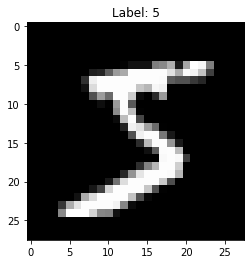

In [3]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

data = mnist.load_data

# Display information about the dataset
print("Train Images Shape:", x_train.shape)
print("Train Labels Length:", len(y_train))
print("Test Images Shape:", x_test.shape)
print("Test Labels Length:", len(y_test))

# Visualize a sample image
import matplotlib.pyplot as plt

plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.show()


In [4]:
# Reshape and normalize the input data
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255

y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

In [5]:
seed_value = 42
tf.random.set_seed(seed_value)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import (Dense, Activation, Flatten, Dropout, Conv2D, Conv2DTranspose,
                                     MaxPooling2D, LeakyReLU, Input)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasRegressor, KerasClassifier
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import pandas as pd
import numpy as np
import os

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

data = mnist.load_data

# Display information about the dataset
print("Train Images Shape:", x_train.shape)
print("Train Labels Length:", len(y_train))
print("Test Images Shape:", x_test.shape)
print("Test Labels Length:", len(y_test))

# Visualize a sample image
import matplotlib.pyplot as plt

plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.show()

# Reshape and normalize the input data
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255

y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

seed_value = 42
tf.random.set_seed(seed_value)

In [9]:
def generate_noise(batch_size, noise_dim):
    return np.random.normal(0, 1, size=(batch_size, noise_dim)).astype(np.float32)

def build_generator(noise_dim, target_image_shape):
    generator = Sequential()

    # Project and reshape the noise
    generator.add(Dense(32, input_dim=noise_dim))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Dropout(rate=0.25))
    generator.add(Dense(784, activation = 'softmax'))
    generator.add(layers.Reshape((target_image_shape[0], target_image_shape[1], 1)))

    # Upsample using Conv2DTranspose layers
    generator.add(Conv2DTranspose(10, kernel_size=3, strides=2, padding='same'))
    generator.add(layers.BatchNormalization())
    generator.add(Dropout(rate=0.25))
    generator.add(LeakyReLU(alpha=0.2))
    
    generator.add(Conv2DTranspose(20, kernel_size=3, strides=2, padding='same'))
    generator.add(layers.BatchNormalization())
    generator.add(Dropout(rate=0.25))
    generator.add(LeakyReLU(alpha=0.2))

    # Output layer
    generator.add(Conv2DTranspose(target_image_shape[1], kernel_size=3, padding='same'))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2D(filters=1, kernel_size=(4, 4), padding='same', strides=2))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2DTranspose(1, kernel_size=1, strides=2, padding='same'))
    generator.add(Conv2D(1, kernel_size =2, strides =2, padding='same'))
    generator.add(Conv2D(1, kernel_size =2, strides =2, padding='same'))
    
    return generator

def build_discriminator(input_shape):
    discriminator = models.Sequential()
    discriminator.add(Conv2D(filters=10, kernel_size=(4, 4), padding='same', input_shape=input_shape, strides=2))
    discriminator.add(Dropout(rate=0.25))
    discriminator.add(MaxPooling2D(pool_size=(1, 1)))
    discriminator.add(Dropout(rate=0.25))
    discriminator.add(Conv2D(filters=10, kernel_size=(4, 4), padding='same', strides=2))
    discriminator.add(MaxPooling2D(pool_size=(1, 1)))
    
    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(80))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(rate=0.25))
    discriminator.add(Dense(40))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(rate=0.25))
    discriminator.add(Dense(20))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(rate=0.25))
    discriminator.add(Dense(1, activation='softmax'))
    return discriminator


def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_model = Sequential()
    gan_model.add(generator)
    gan_model.add(discriminator)
    return gan_model

In [25]:
noise_dim= 28**2
batch_size= 200
target_image_shape= (28, 28, 1)

gen = build_generator(noise_dim, target_image_shape)
gen.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
dis = build_discriminator(target_image_shape)
dis.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


gan = build_gan(gen, dis)
gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


gen.summary()
dis.summary()
gan.summary()

ValueError: Exception encountered when calling layer "sequential_25" (type Sequential).

Input 0 of layer "dense_85" is incompatible with the layer: expected axis -1 of input shape to have value 6272, but received input with shape (None, 25088)

Call arguments received by layer "sequential_25" (type Sequential):
  • inputs=tf.Tensor(shape=(None, 56, 56, 1), dtype=float32)
  • training=None
  • mask=None

In [48]:
total_samples = x_train.shape[0]

# Lists to store loss and accuracy values for plotting
d_loss_values = []
g_loss_values = []
d_accuracy_values = []

# Training loop
epochs = 50

for epoch in range(epochs):
    # Randomly shuffle the dataset
    np.random.shuffle(x_train)
    print(f'Epoch {epoch + 1}/{epochs}')

    # Mini-batch training
    for batch_start in range(0, total_samples, batch_size):
        batch_end = min(batch_start + batch_size, total_samples)

        # Generate random noise
        noise = generate_noise(batch_size, noise_dim)

        # Generate fake images using the generator
        generated_images = gen.predict(noise)

        # Select a batch of real images
        real_images = x_train[batch_start:batch_end]

        # Labels for the discriminator
        fake_labels = np.zeros((batch_size, 1))
        real_labels = np.ones((batch_size, 1))

        # Train the discriminator on real and fake images
        d_loss_fake = dis.train_on_batch(generated_images, fake_labels)
        d_loss_real = dis.train_on_batch(real_images, real_labels)
        d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

        # Generate new noise for the GAN
        noise = generate_noise(batch_size, noise_dim)

        # Labels for the generator (trick the discriminator)
        valid_labels = np.ones((batch_size, 1))

        # Train the GAN (only the generator part)
        g_loss = gan.train_on_batch(noise, valid_labels)

    # Store loss and accuracy values for plotting
    d_loss_values.append(d_loss[0])
    g_loss_values.append(g_loss)
    d_accuracy_values.append(100 * d_loss[1])

    # Print progress
    print(f'D Loss: {d_loss[0]} | D Accuracy: {100 * d_loss[1]} | G Loss: {g_loss}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), d_loss_values, label='Discriminator Loss')
plt.plot(range(1, epochs + 1), g_loss_values, label='Generator Loss')
plt.title('Discriminator and Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), d_accuracy_values, label='Discriminator Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/50
7/7 [==============================] - 1s 167ms/step


KeyboardInterrupt: 

Epoch 0/50
4/4 [==============================] - 0s 33ms/step


4/4 [==============================] - 0s 39ms/step
Epoch 1/50 [D loss: 0.0 | D accuracy: 100.0] [G loss: 15.424948692321777]
1/1 [==============================] - 0s 112ms/step


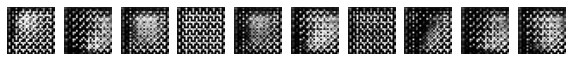

Epoch 1/50
4/4 [==============================] - 0s 32ms/step


4/4 [==============================] - 0s 34ms/step
Epoch 2/50 [D loss: 0.0 | D accuracy: 100.0] [G loss: 15.424948692321777]
Epoch 2/50
4/4 [==============================] - 0s 32ms/step


4/4 [==============================] - 0s 35ms/step


4/4 [==============================] - 0s 32ms/step
Epoch 3/50 [D loss: 2.5343247652053833 | D accuracy: 72.265625] [G loss: 7.000320911407471]
Epoch 3/50
4/4 [==============================] - 0s 32ms/step


4/4 [==============================] - 0s 34ms/step
Epoch 4/50 [D loss: 0.321129709482193 | D accuracy: 90.234375] [G loss: 6.538370132446289]
Epoch 4/50
4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 33ms/step
Epoch 5/50 [D loss: 0.44782792031764984 | D accuracy: 81.25] [G loss: 3.675365924835205]
Epoch 5/50
4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 34ms/step
Epoch 6/50 [D loss: 0.4000699818134308 | D accuracy: 83.984375] [G loss: 2.2691307067871094]
Epoch 6/50
4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 33ms/step


4/4 [==============================] - 0s 38ms/step
Epoch 7/50 [D loss: 0.3423042297363281 | D accuracy: 88.28125] [G loss: 4.57171630859375]
Epoch 7/50
4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 34ms/step
Epoch 8/50 [D loss: 7.579920768737793 | D accuracy: 50.0] [G loss: 0.012198850512504578]
Epoch 8/50
4/4 [==============================] - 0s 36ms/step


4/4 [==============================] - 0s 37ms/step


4/4 [==============================] - 0s 36ms/step
Epoch 9/50 [D loss: 0.27891090512275696 | D accuracy: 89.0625] [G loss: 5.4521684646606445]
Epoch 9/50
4/4 [==============================] - 0s 32ms/step


4/4 [==============================] - 0s 34ms/step
Epoch 10/50 [D loss: 0.3826080411672592 | D accuracy: 84.375] [G loss: 4.666385173797607]
Epoch 10/50
4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 35ms/step
Epoch 11/50 [D loss: 0.37470684945583344 | D accuracy: 82.8125] [G loss: 4.224570274353027]
1/1 [==============================] - 0s 31ms/step


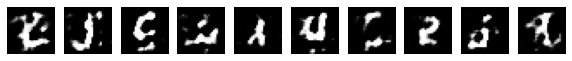

Epoch 11/50
4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 40ms/step
Epoch 12/50 [D loss: 0.35336628556251526 | D accuracy: 89.84375] [G loss: 5.210386753082275]
Epoch 12/50
4/4 [==============================] - 0s 30ms/step


4/4 [==============================] - 0s 36ms/step
Epoch 13/50 [D loss: 0.29089606553316116 | D accuracy: 90.625] [G loss: 6.009893417358398]
Epoch 13/50
4/4 [==============================] - 0s 31ms/step


4/4 [==============================] - 0s 40ms/step


4/4 [==============================] - 0s 35ms/step
Epoch 14/50 [D loss: 3.840874195098877 | D accuracy: 55.46875] [G loss: 6.935801029205322]
Epoch 14/50
4/4 [==============================] - 0s 35ms/step


4/4 [==============================] - 0s 33ms/step
Epoch 15/50 [D loss: 7.624619007110596 | D accuracy: 50.0] [G loss: 0.0]
Epoch 15/50
4/4 [==============================] - 0s 32ms/step


4/4 [==============================] - 0s 36ms/step


4/4 [==============================] - 0s 35ms/step
Epoch 16/50 [D loss: 0.8567834049463272 | D accuracy: 68.359375] [G loss: 3.888944149017334]
Epoch 16/50
4/4 [==============================] - 0s 35ms/step


4/4 [==============================] - 0s 34ms/step
Epoch 17/50 [D loss: 6.868864804506302 | D accuracy: 47.65625] [G loss: 0.4346781373023987]
Epoch 17/50
4/4 [==============================] - 0s 37ms/step


4/4 [==============================] - 0s 33ms/step


4/4 [==============================] - 0s 37ms/step
Epoch 18/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
Epoch 18/50
4/4 [==============================] - 0s 33ms/step


4/4 [==============================] - 0s 33ms/step
Epoch 19/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
Epoch 19/50
4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 40ms/step


4/4 [==============================] - 0s 34ms/step
Epoch 20/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
Epoch 20/50
4/4 [==============================] - 0s 33ms/step


4/4 [==============================] - 0s 33ms/step
Epoch 21/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
1/1 [==============================] - 0s 29ms/step


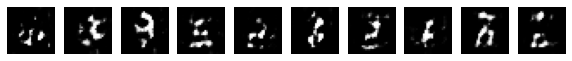

Epoch 21/50
4/4 [==============================] - 0s 33ms/step


4/4 [==============================] - 0s 34ms/step
Epoch 22/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
Epoch 22/50
4/4 [==============================] - 0s 33ms/step


4/4 [==============================] - 0s 33ms/step
Epoch 23/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
Epoch 23/50
4/4 [==============================] - 0s 36ms/step


4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 33ms/step
Epoch 24/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
Epoch 24/50
4/4 [==============================] - 0s 37ms/step


4/4 [==============================] - 0s 34ms/step
Epoch 25/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
Epoch 25/50
4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 34ms/step
Epoch 26/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
Epoch 26/50
4/4 [==============================] - 0s 33ms/step


4/4 [==============================] - 0s 34ms/step
Epoch 27/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
Epoch 27/50
4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 39ms/step


4/4 [==============================] - 0s 35ms/step
Epoch 28/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
Epoch 28/50
4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 34ms/step
Epoch 29/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
Epoch 29/50
4/4 [==============================] - 0s 33ms/step


4/4 [==============================] - 0s 34ms/step


4/4 [==============================] - 0s 34ms/step
Epoch 30/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
Epoch 30/50
4/4 [==============================] - 0s 32ms/step


4/4 [==============================] - 0s 37ms/step
Epoch 31/50 [D loss: 7.712474346160889 | D accuracy: 50.0] [G loss: 15.424948692321777]
1/1 [==============================] - 0s 33ms/step


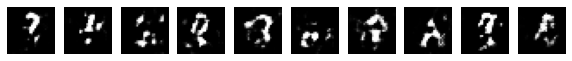

Epoch 31/50
4/4 [==============================] - 0s 32ms/step


KeyboardInterrupt: 

In [64]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

# Define the generator model
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# Create the generator
generator = build_generator()

# Define the discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Create the discriminator
discriminator = build_discriminator()

# Compile the discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Build and compile the combined model (generator and discriminator)
discriminator.trainable = False  # Fix the discriminator during combined model training

gan_input = tf.keras.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = tf.keras.models.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy')

# Training the GAN
def train_gan(epochs, batch_size):
    #use difference in a for loop so if the net hasnt converged by the end keeps ading 10 epochs until reaching
    #cuttoff, else set epochs to 0 and begin training generator
    
    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs}")
        for _ in range(train_images.shape[0] // batch_size):
            noise = np.random.normal(0, 1, size=(batch_size, 100))
            generated_images = generator.predict(noise)

            real_images = train_images[np.random.randint(0, train_images.shape[0], batch_size)]

            labels_real = np.ones((batch_size, 1))
            labels_fake = np.zeros((batch_size, 1))

            d_loss_real = discriminator.train_on_batch(real_images, labels_real)
            d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, size=(batch_size, 100))
            labels_gan = np.ones((batch_size, 1))

            g_loss = gan.train_on_batch(noise, labels_gan)

        print(f"Epoch {epoch+1}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        if epoch % 10 == 0:
            generate_and_save_images(generator, epoch + 1)

# Function to generate and save images
def generate_and_save_images(model, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, size=(examples, 100))
    generated_images = model.predict(noise)
    generated_images = generated_images * 0.5 + 0.5  # Rescale images to [0, 1]

    fig, axs = plt.subplots(dim[0], dim[1], figsize=figsize)
    for i in range(dim[0] * dim[1]):
        axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axs[i].axis('off')
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.show()

# Train the GAN
train_gan(epochs=50, batch_size=128)


In [24]:
def generate_noise(batch_size, noise_dim):
    return np.random.normal(0, 1, size=(batch_size, noise_dim)).astype(np.float32)

def build_generator(noise_dim, target_image_shape):
    generator = Sequential()

    # Project and reshape the noise
    generator.add(Dense(32, input_dim=noise_dim))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Dense(64, input_dim=noise_dim))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Dropout(rate=0.2))
    generator.add(Dense(128, input_dim=noise_dim))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(Dropout(rate=0.2))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Dense(512, input_dim=noise_dim))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Dense(784, activation = 'tanh'))
    generator.add(layers.Reshape((target_image_shape[0], target_image_shape[1], 1)))

    # Upsample using Conv2DTranspose layers
    generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    generator.add(layers.BatchNormalization())
    generator.add(Dropout(rate=0.2))
    generator.add(LeakyReLU(alpha=0.2))
    
    generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    generator.add(layers.BatchNormalization())
    generator.add(LeakyReLU(alpha=0.2))

    # Output layer
    generator.add(Conv2DTranspose(target_image_shape[1], kernel_size=3, padding='same'))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2D(filters=256, kernel_size=(4, 4), padding='same', strides=2))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2DTranspose(128, kernel_size=1, strides=2, padding='same'))
    generator.add(Conv2D(64, kernel_size =2, strides =2, padding='same'))
    generator.add(Conv2D(1, kernel_size =1, strides =1, padding='same'))
    
    return generator

def build_discriminator(input_shape):
    discriminator = models.Sequential()
    discriminator.add(Conv2D(filters=64, kernel_size=(2, 2), padding='same', input_shape=input_shape, strides=(2,1)))
    discriminator.add(Dropout(rate=0.2))
    discriminator.add(MaxPooling2D(pool_size=(2, 1)))
    discriminator.add(Conv2D(filters=64, kernel_size=(2, 2), padding='same', strides=(1,2)))
    discriminator.add(MaxPooling2D(pool_size=(1, 2)))

    discriminator.add(Conv2D(filters=128, kernel_size=(2, 2), padding='same', strides=(1,1)))
    #discriminator.add(MaxPooling2D(pool_size=(1, 2)))
    
    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(512))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(rate=0.2))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dense(128))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(rate=0.2))
    discriminator.add(Dense(64))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dense(1, activation='sigmoid'))
    return discriminator



def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_model = Sequential()
    gan_model.add(generator)
    gan_model.add(discriminator)
    return gan_model


noise_dim= 28**2
batch_size= 200
target_image_shape= (28, 28, 1)

gen = build_generator(noise_dim, target_image_shape)
gen.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
dis = build_discriminator(target_image_shape)
dis.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


gan = build_gan(gen, dis)
gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


gen.summary()
dis.summary()
gan.summary()

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

# Define the generator model
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(7 * 7 * 32, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(Dropout(rate=0.1))
    model.add(layers.Dense(7 * 7 * 64, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 64)))
    #print(f'Model Shape {model.output_shape}')
    assert model.output_shape == (None, 7, 7, 64), f'Model Shape {model.output_shape}'

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #print(f'Model Shape {model.output_shape}')
    assert model.output_shape == (None, 7, 7, 64), f'Model Shape {model.output_shape}'
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(Dropout(rate=0.2))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    #print(f'Model Shape {model.output_shape}')
    assert model.output_shape == (None, 14, 14, 128), f'Model Shape {model.output_shape}'
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 64), f'Model Shape {model.output_shape}'
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(Dropout(rate=0.2))
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation = 'tanh'))
    assert model.output_shape == (None, 28, 28, 1), f'Model Shape {model.output_shape}'

    return model

# Create the generator
generator = build_generator()

# Define the discriminator model
def build_discriminator(input_shape=(28, 28, 1)):
    discriminator = models.Sequential()
    discriminator.add(Conv2D(filters=64, kernel_size=(2, 2), padding='same', input_shape=input_shape, strides=(2,1)))
    discriminator.add(Dropout(rate=0.2))
    discriminator.add(MaxPooling2D(pool_size=(2, 1)))
    discriminator.add(Conv2D(filters=64, kernel_size=(2, 2), padding='same', strides=(1,2)))
    discriminator.add(MaxPooling2D(pool_size=(1, 2)))

    discriminator.add(Conv2D(filters=128, kernel_size=(2, 2), padding='same', strides=(1,1)))
    #discriminator.add(MaxPooling2D(pool_size=(1, 2)))
    
    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(512))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(rate=0.2))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dense(128))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(rate=0.2))
    discriminator.add(Dense(64))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dense(1, activation='sigmoid'))
    
    return discriminator

# Create the discriminator
discriminator = build_discriminator()

# Compile the discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Build and compile the combined model (generator and discriminator)
discriminator.trainable = False  # Fix the discriminator during combined model training

gan_input = tf.keras.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = tf.keras.models.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy')

# Training the GAN
def train_gan(epochs, batch_size):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for _ in range(train_images.shape[0] // batch_size):
            noise = np.random.normal(0, 1, size=(batch_size, 100))
            generated_images = generator.predict(noise)

            real_images = train_images[np.random.randint(0, train_images.shape[0], batch_size)]

            labels_real = np.ones((batch_size, 1))
            labels_fake = np.zeros((batch_size, 1))

            d_loss_real = discriminator.train_on_batch(real_images, labels_real)
            d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, size=(batch_size, 100))
            labels_gan = np.ones((batch_size, 1))

            g_loss = gan.train_on_batch(noise, labels_gan)

        print(f"Epoch {epoch+1}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        if (epoch+1) % 2 == 0:
            generate_and_save_images(generator, epoch + 1)

# Function to generate and save images
def generate_and_save_images(model, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, size=(examples, 100))
    generated_images = model.predict(noise)
    generated_images = generated_images * 0.5 + 0.5  # Rescale images to [0, 1]

    fig, axs = plt.subplots(dim[0], dim[1], figsize=figsize)
    for i in range(dim[0] * dim[1]):
        axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axs[i].axis('off')
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.show()

# Train the GAN



Train Images Shape: (60000, 28, 28)
Train Labels Length: 60000
Test Images Shape: (10000, 28, 28)
Test Labels Length: 10000


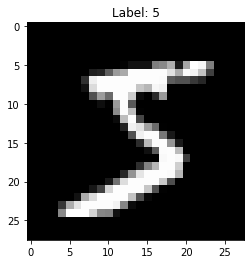

In [40]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import (Dense, Activation, Flatten, Dropout, Conv2D, Conv2DTranspose,
                                     MaxPooling2D, LeakyReLU, Input)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasRegressor, KerasClassifier
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import pandas as pd
import numpy as np
import os

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

data = mnist.load_data

# Display information about the dataset
print("Train Images Shape:", x_train.shape)
print("Train Labels Length:", len(y_train))
print("Test Images Shape:", x_test.shape)
print("Test Labels Length:", len(y_test))

# Visualize a sample image
import matplotlib.pyplot as plt

plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.show()

# Reshape and normalize the input data
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255

y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

seed_value = 42
tf.random.set_seed(seed_value)

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

# Define the generator model
def build_generator():
    model = models.Sequential()
    
    model.add(layers.Dense(7 * 7 * 64, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(Dropout(rate=0.2))
    model.add(layers.LeakyReLU())
    model.add(Dropout(rate=0.2))

    model.add(layers.Dense(7 * 7 * 64, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(Dropout(rate=0.2))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(7 * 7 * 128, use_bias=False, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(Dropout(rate=0.2))
    
    model.add(layers.Dense(7 * 7 * 128, use_bias=False, kernel_regularizer=regularizers.l2(0.01), 
                           activation = 'tanh'))
    #model.add(layers.LeakyReLU())
    
    #model.add(layers.Dense(7 * 7 * 256, use_bias=False, activation = 'tanh', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Reshape((7, 7, 128)))

    assert model.output_shape == (None, 7, 7, 128), f'Model Shape {model.output_shape}'

    model.add(layers.Conv2DTranspose(128, (6, 6), strides=(2, 2), padding='same', use_bias=False))
    #print(f'Model Shape {model.output_shape}')
    assert model.output_shape == (None, 14, 14, 128), f'Model Shape {model.output_shape}'
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(Dropout(rate=0.2))

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    #print(f'Model Shape {model.output_shape}')
    assert model.output_shape == (None, 28, 28, 128), f'Model Shape {model.output_shape}'
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(Dropout(rate=0.2))

#    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #print(f'Model Shape {model.output_shape}')
#    assert model.output_shape == (None, 28, 28, 128), f'Model Shape {model.output_shape}'
 #   model.add(layers.BatchNormalization())
  #  model.add(Dropout(rate=0.2))
   # model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', use_bias=False))
    #print(f'Model Shape {model.output_shape}')
    assert model.output_shape == (None, 28, 28, 128), f'Model Shape {model.output_shape}'
    model.add(layers.BatchNormalization())
    model.add(Dropout(rate=0.2))
    model.add(layers.LeakyReLU())
    
#    model.add(layers.Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    #print(f'Model Shape {model.output_shape}')
 #   assert model.output_shape == (None, 28, 28, 256), f'Model Shape {model.output_shape}'
  #  model.add(layers.BatchNormalization())
   # model.add(Dropout(rate=0.2))
    #model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (1, 2), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 128), f'Model Shape {model.output_shape}'
    model.add(Dropout(rate=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (2, 1), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 128), f'Model Shape {model.output_shape}'
    model.add(layers.BatchNormalization())
    model.add(Dropout(rate=0.2))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (2, 2), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 1), f'Model Shape {model.output_shape}'
    model.add(layers.BatchNormalization())
    model.add(Dropout(rate=0.2))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, 
                                     activation = 'tanh'))
    assert model.output_shape == (None, 28, 28, 1), f'Model Shape {model.output_shape}'

    return model

# Create the generator
generator = build_generator()

# Define the discriminator model
def build_discriminator(input_shape=(28, 28, 1)):
    discriminator = models.Sequential()
    discriminator.add(Conv2D(filters=64, kernel_size=(2, 2), padding='same', input_shape=input_shape, strides=(2,1)))
    discriminator.add(Dropout(rate=0.2))
    discriminator.add(MaxPooling2D(pool_size=(2, 1)))
    discriminator.add(Conv2D(filters=64, kernel_size=(2, 2), padding='same', strides=(1,2)))
    discriminator.add(MaxPooling2D(pool_size=(1, 2)))

    discriminator.add(Conv2D(filters=128, kernel_size=(2, 2), padding='same', strides=(1,1)))
    #discriminator.add(MaxPooling2D(pool_size=(1, 2)))
    
    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(512))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(rate=0.2))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dense(128))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(rate=0.2))
    discriminator.add(Dense(64))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dense(1, activation='sigmoid'))
    
    return discriminator

# Create the discriminator
discriminator = build_discriminator()

# Compile the discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Build and compile the combined model (generator and discriminator)
discriminator.trainable = False  # Fix the discriminator during combined model training

gan_input = tf.keras.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = tf.keras.models.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the GAN
def train_step(generator, discriminator, gan, batch_size):
    noise = np.random.normal(0, 1, size=(batch_size, 100))
    generated_images = generator.predict(noise)

    real_images = train_images[np.random.randint(0, train_images.shape[0], batch_size)]

    labels_real = np.ones((batch_size, 1))
    labels_fake = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, size=(batch_size, 100))
    labels_gan = np.ones((batch_size, 1))

    g_loss = gan.train_on_batch(noise, labels_gan)

    return d_loss, g_loss


def train_gan(epochs, batch_size):
    d_losses = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        np.random.shuffle(train_images)
        for _ in range(train_images.shape[0] // batch_size):
            noise = np.random.normal(0, 1, size=(batch_size, 100))
            generated_images = generator.predict(noise)

            real_images = train_images[np.random.randint(0, train_images.shape[0], batch_size)]

            labels_real = np.ones((batch_size, 1))
            labels_fake = np.zeros((batch_size, 1))

            d_loss_real = discriminator.train_on_batch(real_images, labels_real)
            d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                    
            noise = np.random.normal(0, 1, size=(batch_size, 100))
            labels_gan = np.ones((batch_size, 1))

            g_loss = gan.train_on_batch(noise, labels_gan)

        print(f"Epoch {epoch+1}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        if (epoch+1) % 2 == 0:
            generate_and_save_images(generator, epoch + 1)
            
    return trained_gan
            
        #if early_stopping.model.stop_training:
         #   print("Training stopped early.")
          #  break

# Function to generate and save images
def generate_and_save_images(model, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, size=(examples, 100))
    generated_images = model.predict(noise)
    generated_images = generated_images * 0.5 + 0.5  # Rescale images to [0, 1]

    fig, axs = plt.subplots(dim[0], dim[1], figsize=figsize)
    for i in range(dim[0] * dim[1]):
        axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axs[i].axis('off')
    plt.savefig(f"figures\gan\gan_generated_image_epoch_{epoch}.png")
    plt.show()

# Train the GAN



In [44]:
generator.summary()
discriminator.summary()
gan.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138 (Dense)           (None, 3136)              313600    
                                                                 
 batch_normalization_178 (B  (None, 3136)              12544     
 atchNormalization)                                              
                                                                 
 dropout_220 (Dropout)       (None, 3136)              0         
                                                                 
 leaky_re_lu_217 (LeakyReLU  (None, 3136)              0         
 )                                                               
                                                                 
 dropout_221 (Dropout)       (None, 3136)              0         
                                                                 
 dense_139 (Dense)           (None, 3136)            

                                                                 
 conv2d_43 (Conv2D)          (None, 7, 14, 64)         16448     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 7, 7, 128)         32896     
                                                                 
 flatten_14 (Flatten)        (None, 6272)              0         
                                                                 
 dense_142 (Dense)           (None, 512)               3211776   
                                                                 
 leaky_re_lu_226 (LeakyReLU  (None, 512)               0         
 )                                                               
                                                                 
 dropout_2

Epoch 1/100
2/2 [==============================] - 0s 171ms/step


2/2 [==============================] - 0s 163ms/step


2/2 [==============================] - 0s 166ms/step


2/2 [==============================] - 0s 158ms/step
Epoch 1/100 [D loss: 0.33606837689876556 | D accuracy: 87.5] [G loss: 7.30884313583374]
Epoch 2/100
2/2 [==============================] - 0s 163ms/step


2/2 [==============================] - 0s 168ms/step


2/2 [==============================] - 0s 162ms/step


2/2 [==============================] - 0s 158ms/step
Epoch 2/100 [D loss: 0.5999064743518829 | D accuracy: 64.0625] [G loss: 4.552609920501709]
1/1 [==============================] - 0s 408ms/step


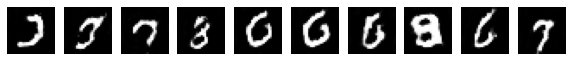

Epoch 3/100
2/2 [==============================] - 0s 162ms/step


2/2 [==============================] - 0s 177ms/step


2/2 [==============================] - 0s 167ms/step


2/2 [==============================] - 0s 165ms/step
Epoch 3/100 [D loss: 0.5307814478874207 | D accuracy: 72.65625] [G loss: 6.286271095275879]
Epoch 4/100
2/2 [==============================] - 0s 198ms/step


2/2 [==============================] - 0s 167ms/step


2/2 [==============================] - 0s 169ms/step


2/2 [==============================] - 0s 171ms/step
Epoch 4/100 [D loss: 0.427746519446373 | D accuracy: 82.8125] [G loss: 7.264420509338379]
1/1 [==============================] - 0s 122ms/step


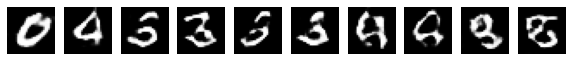

Epoch 5/100
2/2 [==============================] - 0s 162ms/step


2/2 [==============================] - 0s 161ms/step


2/2 [==============================] - 0s 164ms/step


2/2 [==============================] - 0s 162ms/step
Epoch 5/100 [D loss: 0.49421072006225586 | D accuracy: 73.4375] [G loss: 6.545650482177734]
Epoch 6/100
2/2 [==============================] - 0s 166ms/step


2/2 [==============================] - 0s 181ms/step


2/2 [==============================] - 0s 165ms/step


2/2 [==============================] - 0s 156ms/step
Epoch 6/100 [D loss: 0.4677300304174423 | D accuracy: 73.4375] [G loss: 5.948451995849609]
1/1 [==============================] - 0s 93ms/step


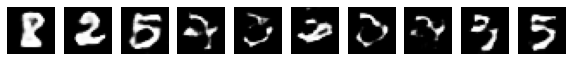

Epoch 7/100
2/2 [==============================] - 0s 171ms/step


2/2 [==============================] - 0s 171ms/step


2/2 [==============================] - 0s 159ms/step


2/2 [==============================] - 0s 156ms/step
Epoch 7/100 [D loss: 0.35392044484615326 | D accuracy: 82.8125] [G loss: 6.185208797454834]
Epoch 8/100
2/2 [==============================] - 0s 158ms/step


2/2 [==============================] - 0s 166ms/step


2/2 [==============================] - 0s 164ms/step


2/2 [==============================] - 0s 160ms/step
Epoch 8/100 [D loss: 0.39489680528640747 | D accuracy: 82.8125] [G loss: 5.341811180114746]
1/1 [==============================] - 0s 92ms/step


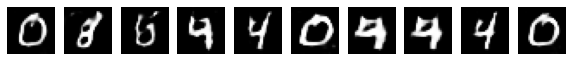

Epoch 9/100
2/2 [==============================] - 0s 158ms/step


2/2 [==============================] - 0s 172ms/step


KeyboardInterrupt: 

In [45]:
discriminator.trainable = False

trained_gan = train_gan(100, 64)